<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/6_5_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

## Conditional GAN

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchviz import make_dot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__

'2.0.1+cu118'

- model params

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 600
label_dim=10    # class_num.
noise_dim = 90  # latent vector dim.
IN_PUT_DIM=label_dim+noise_dim  # 100
num_examples_to_generate = 16
IMG_SHAPE=(28,28,1)

### Dataset 준비

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST

class Normalize(object):
    def __call__(self, sample):
        sample = np.array(sample)
        image = (sample - 127.5) / 127.5
        image = torch.FloatTensor(image).unsqueeze(dim=0)
        return image #(1,28,28)

class Onehot(object):
    def __call__(self, sample):
        target = torch.eye(10)[sample]  #(b,10)
        return target

# Normalize data to [-1 ~ 1]
mnist_transform = transforms.Compose([Normalize()])
target_transform = transforms.Compose([Onehot()])

# download path 정의
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True, target_transform=target_transform)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True, target_transform=target_transform)

In [ ]:
ps(train_dataset[0][0]),train_dataset[0][1]

[] Shapetorch.Size([1, 28, 28])


(None, tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


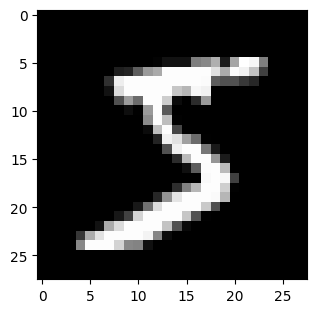

In [ ]:
plt.imshow(train_dataset[0][0][0], cmap='gray') # 첫번째 이미지와
print(train_dataset[0][1])                      # 그 label(one-hot coding)

In [ ]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, False)

### Model define

- Generator 생성 함수

In [ ]:
device = 'cuda:0'

In [ ]:
# Generator model
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(input_dim, 256 * 7 * 7, bias=False),
            nn.Unflatten(1, (256, 7, 7)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 5, 1,
                          padding=2, bias=False),
            nn.BatchNorm2d(128), #(128,7,7)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2,
                         padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64), #(64,14,14)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 5, 2,
                         padding=2, output_padding=1, bias=False),
            nn.Tanh() )         #(1,28,28)
    def forward(self, z, c):
        c = c.to(device)
        inputs = torch.cat([z, c], dim=1)
        out = self.generator(inputs)
        return out

z_vector = torch.randn((BATCH_SIZE, noise_dim), device=device)
generator = Generator(IN_PUT_DIM).to(device)
summary(generator, input_size=[(BATCH_SIZE, noise_dim), (BATCH_SIZE, label_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [600, 1, 28, 28]          --
├─Sequential: 1-1                        [600, 1, 28, 28]          --
│    └─Linear: 2-1                       [600, 12544]              1,254,400
│    └─Unflatten: 2-2                    [600, 256, 7, 7]          --
│    └─BatchNorm2d: 2-3                  [600, 256, 7, 7]          512
│    └─LeakyReLU: 2-4                    [600, 256, 7, 7]          --
│    └─ConvTranspose2d: 2-5              [600, 128, 7, 7]          819,200
│    └─BatchNorm2d: 2-6                  [600, 128, 7, 7]          256
│    └─LeakyReLU: 2-7                    [600, 128, 7, 7]          --
│    └─ConvTranspose2d: 2-8              [600, 64, 14, 14]         204,800
│    └─BatchNorm2d: 2-9                  [600, 64, 14, 14]         128
│    └─LeakyReLU: 2-10                   [600, 64, 14, 14]         --
│    └─ConvTranspose2d: 2-11             [600, 1, 28, 28]        

- Discriminator 생성 함수

In [ ]:
IMG_SHAPE

(28, 28, 1)

In [ ]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, label_dim):
        super(Discriminator, self).__init__()
        self.categoryLinear = nn.Sequential(
            nn.Linear(label_dim, 28*28),
            nn.Unflatten(1, (1, 28, 28)) )
        self.discriminator = nn.Sequential(
            nn.Conv2d(2, 64, 5, 2, padding=2), #(64,14,14)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, 2, padding=2),#(128,7,7)
            nn.LeakyReLU(),
            nn.Flatten(),                       #(6272,)
            nn.Linear(128*7*7, 1),
            nn.Sigmoid() )
    def forward(self, x, c):                 #x:(1,28,28)
        cat_out = self.categoryLinear(c)       #(1,28,28)
        inputs = torch.cat([x, cat_out], dim=1)#(2,28,28)
        out = self.discriminator(inputs)
        return out

discriminator = Discriminator(label_dim).to(device)
summary(discriminator, input_size=[(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, label_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [600, 1]                  --
├─Sequential: 1-1                        [600, 1, 28, 28]          --
│    └─Linear: 2-1                       [600, 784]                8,624
│    └─Unflatten: 2-2                    [600, 1, 28, 28]          --
├─Sequential: 1-2                        [600, 1]                  --
│    └─Conv2d: 2-3                       [600, 64, 14, 14]         3,264
│    └─LeakyReLU: 2-4                    [600, 64, 14, 14]         --
│    └─Conv2d: 2-5                       [600, 128, 7, 7]          204,928
│    └─LeakyReLU: 2-6                    [600, 128, 7, 7]          --
│    └─Flatten: 2-7                      [600, 6272]               --
│    └─Linear: 2-8                       [600, 1]                  6,273
│    └─Sigmoid: 2-9                      [600, 1]                  --
Total params: 223,089
Trainable params: 223,089
Non-trainable params: 0

### Model들 생성 및 학습조건 설정

- 이미지 생성 및 저장 함수

In [ ]:
def generate_and_save_images(gen, epoch):
    r, c = 10, 10
    fig = plt.figure(figsize=(5,5))
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(c):
        sampled_noise, _ = generator_input(c) # Fake label은 버리고
        # 0~9 까지 새로운 label생성
        new_label = np.eye(r, 10)[
          np.full(fill_value=i, shape=(r))] # 10개씩 준비
        # z와 new_label 10개를 입력으로 이미지 추론
        gen_imgs = generator(torch.FloatTensor(sampled_noise).to(device), torch.FloatTensor(new_label).to(device))###
        gen_imgs = 0.5 * gen_imgs + 0.5  # (0~1)<-(-1~1) scaling
        for j in range(r):
            ax = fig.add_subplot(r, c, j * r + i + 1)
            ax.imshow(gen_imgs.cpu().detach().numpy()[j,0, :, :], cmap=plt.cm.bone)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

- Generator 입력으로 들어가는 z_vetor와 Fake label생성

In [ ]:
def generator_input(batch_size):
    # Generator inputs
    sampled_noise = torch.randn(batch_size, noise_dim) #(b,90)
    sampled_labels = torch.randint(10, (batch_size,))  #(b,)
    sampled_labels = torch.eye(10)[sampled_labels]  #(b,10)
    return sampled_noise, sampled_labels #((b,90),(b,10))

ps(generator_input(2)[1]) #labels(b,10)

[] Shapetorch.Size([2, 10])


In [ ]:
lr = 2e-4
loss_function = nn.BCELoss()

generator = generator.to(device)
discriminator = discriminator.to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)

### Training

Epoch: 0 Loss D.: 0.024390045553445816
Epoch: 0 Loss G.: 4.350047588348389


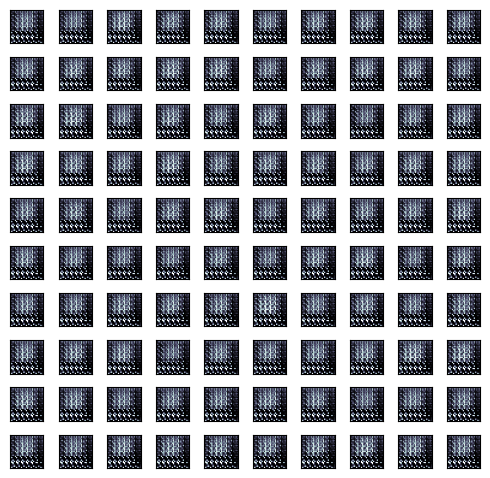

Epoch: 10 Loss D.: 0.09136971086263657
Epoch: 10 Loss G.: 4.378132343292236


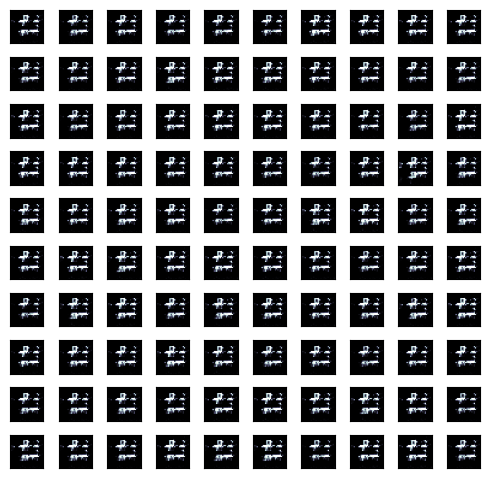

Epoch: 20 Loss D.: 0.08066022396087646
Epoch: 20 Loss G.: 3.492741346359253


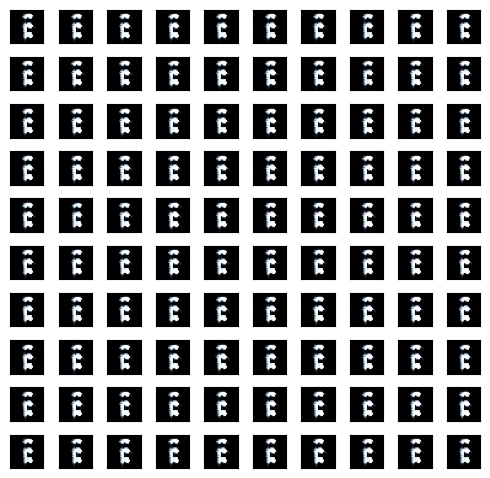

Epoch: 30 Loss D.: 0.02706890180706978
Epoch: 30 Loss G.: 4.889128684997559


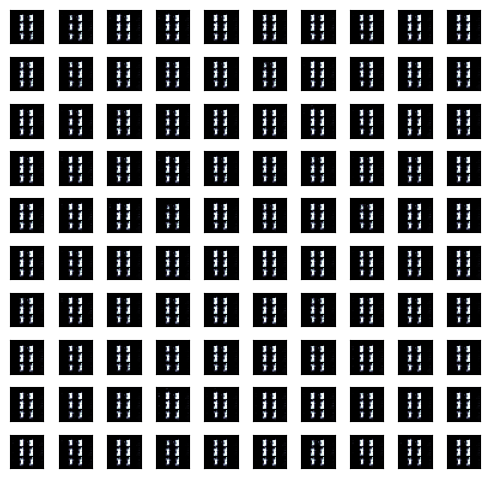

KeyboardInterrupt: ignored

In [ ]:
%%time
EPOCHS = 100
generator.train()
discriminator.train()
for epoch in range(EPOCHS):
    for image_batch, real_label in train_dataloader:
        image_batch = image_batch.to(device)
        real_label = real_label.to(device)
        noise, f_labels = generator_input(BATCH_SIZE)
        noise, f_labels = noise.to(device), f_labels.to(device)
        f_img = generator(noise, f_labels)
        con_imgs = torch.cat([image_batch,f_img])
        con_labels = torch.cat([real_label,f_labels])
        y_r = torch.ones((BATCH_SIZE,1)).to(device)
        y_f = torch.zeros((BATCH_SIZE,1)).to(device)
        con_y = torch.cat([y_r,y_f])
        # Discriminator
        discriminator.zero_grad()
        out_dis = discriminator(con_imgs, con_labels)
        loss_d = loss_function(out_dis, con_y)
        loss_d.backward()
        optimizer_d.step()
        # Generator
        noise, f_labels = generator_input(BATCH_SIZE)
        noise, f_labels = noise.to(device), f_labels.to(device)
        generator.zero_grad()
        f_img = generator(noise, f_labels)
        out_dis = discriminator(f_img, f_labels)
        loss_g = loss_function(out_dis, y_r)
        loss_g.backward()
        optimizer_g.step()

    # Show loss
    if epoch % 10 == 0:  #10 #학습된 gen.의 성능 확인
        print(f"Epoch: {epoch} Loss D.: {loss_d}")
        print(f"Epoch: {epoch} Loss G.: {loss_g}")
        generate_and_save_images(generator, epoch)

### Model save&load

In [ ]:
# # gdriver mount to load saved model
from google.colab import drive
drive.mount('./gdrive')
save_path="./gdrive/MyDrive/Colab Notebooks/models/"

Mounted at ./gdrive


In [ ]:
torch.save(discriminator, save_path+'discriminator.pt')
torch.save(generator, save_path+'generator.pt')

In [ ]:
discriminator = torch.load(save_path+'discriminator.pt')
generator = torch.load(save_path+'generator.pt')

-  Generator model을 load하여 원하는 글자 생성하기

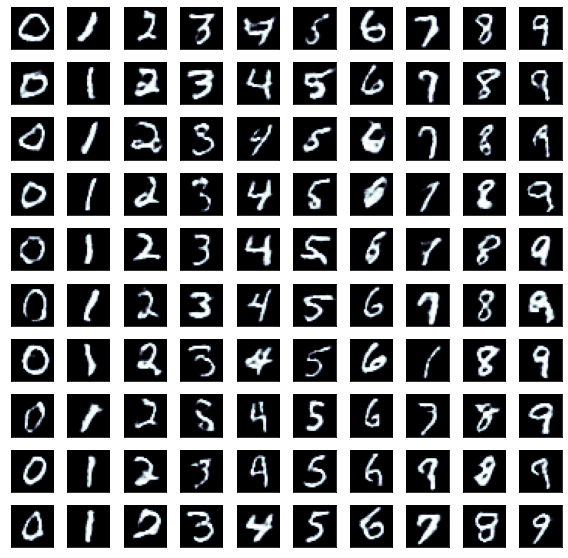

In [ ]:
r, c = 10, 10
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
#fig, axs = plt.subplots(r, c)
for i in range(c):
    sampled_noise, _ = generator_input(c) # Fake label은 버리고
    # 0~9 까지 새로운 label생성
    new_label = np.eye(r, 10)[
          np.full(fill_value=i, shape=(r))] # 10개씩 준비
        # z와 new_label 10개를 입력으로 이미지 추론
    gen_imgs = generator(sampled_noise.to(device), torch.Tensor(new_label).to(device))
    gen_imgs = 0.5 * gen_imgs + 0.5  # (0~1)<-(-1~1) scaling
    for j in range(r):
        ax = fig.add_subplot(r, c, j * r + i + 1)
        ax.imshow(gen_imgs.cpu().detach().numpy()[j,0, :, :], cmap=plt.cm.bone)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

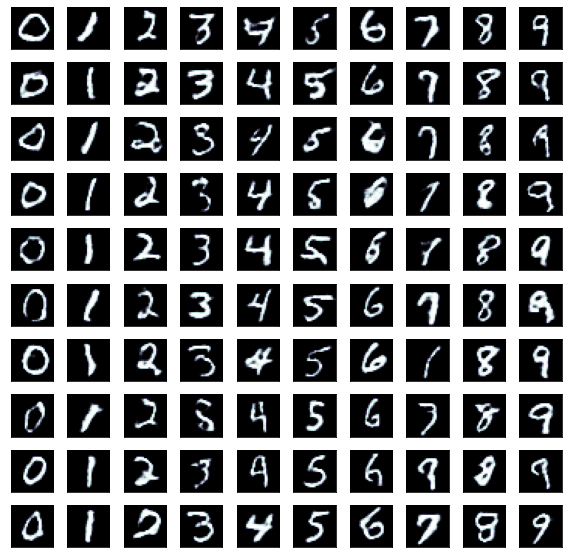

### 동영상 만들기 : png 묶어서 동영상 만드는 코드
> 실습환경에서는 동작 안할겁니다.참고용!

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
#!conda install imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [ ]:
from google.colab import files

anim_file = 'cgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        files.download(filename)
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filenames)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

## ACGAN

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchviz import make_dot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython import display
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__

'2.0.1+cu118'

### Dataset 준비

In [ ]:
# import torchvision.transforms as transforms
# from torchvision.datasets import FashionMNIST, MNIST

# class Normalize(object):
#     def __call__(self, sample):
#         sample = np.array(sample)
#         image = (sample - 127.5) / 127.5
#         return torch.FloatTensor(image).unsqueeze(dim=0)

# class Onehot(object):
#     def __call__(self, sample):
#         sample = sample
#         target = np.eye(10)[sample]
#         return torch.FloatTensor(target)

# # Normalize data to [-1 ~ 1]
# mnist_transform = transforms.Compose([
#     Normalize(), # noise add
# ])
# target_transform = transforms.Compose([
#     Onehot(), # noise add
# ])

# # download path 정의
# download_root = './MNIST_DATASET'
# train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True, target_transform=target_transform)
# test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True, target_transform=target_transform)

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


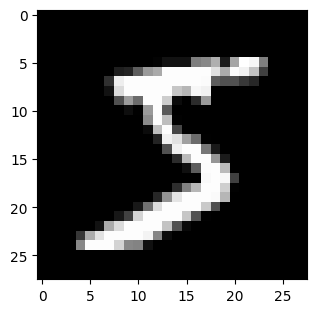

In [ ]:
plt.imshow(train_dataset[0][0][0, :, :], cmap='gray')
print(train_dataset[0][1])

- model params

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 600
EPOCHS = 200
label_dim=10    # class_num.
noise_dim = 90  # latent vector dim.
IN_PUT_DIM=label_dim+noise_dim  # 100
num_examples_to_generate = 16
IMG_SHAPE=(28,28,1)

In [ ]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, False)

### Model define

In [ ]:
device = 'cuda:0'

In [ ]:
# Generator model : CGAN과 동일
class ACGenerator(nn.Module):
    def __init__(self, input_dim):
        super(ACGenerator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(input_dim, 256 * 7 * 7, bias=False),
            nn.Unflatten(1, (256, 7, 7)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 5, 1,
                        padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2,
                        padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 5, 2,
                        padding=2, output_padding=1, bias=False),
            nn.Tanh() )
    def forward(self, z, c):
        c = c.to(device)
        inputs = torch.cat([z, c], dim=1)
        out = self.generator(inputs)
        return out

z_vector = torch.randn((BATCH_SIZE, noise_dim), device=device)
acgenerator = ACGenerator(IN_PUT_DIM).to(device)
summary(acgenerator, input_size=[(BATCH_SIZE, noise_dim), (BATCH_SIZE, label_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
ACGenerator                              [600, 1, 28, 28]          --
├─Sequential: 1-1                        [600, 1, 28, 28]          --
│    └─Linear: 2-1                       [600, 12544]              1,254,400
│    └─Unflatten: 2-2                    [600, 256, 7, 7]          --
│    └─BatchNorm2d: 2-3                  [600, 256, 7, 7]          512
│    └─LeakyReLU: 2-4                    [600, 256, 7, 7]          --
│    └─ConvTranspose2d: 2-5              [600, 128, 7, 7]          819,200
│    └─BatchNorm2d: 2-6                  [600, 128, 7, 7]          256
│    └─LeakyReLU: 2-7                    [600, 128, 7, 7]          --
│    └─ConvTranspose2d: 2-8              [600, 64, 14, 14]         204,800
│    └─BatchNorm2d: 2-9                  [600, 64, 14, 14]         128
│    └─LeakyReLU: 2-10                   [600, 64, 14, 14]         --
│    └─ConvTranspose2d: 2-11             [600, 1, 28, 28]        

In [ ]:
# ACDiscriminator model
class ACDiscriminator(nn.Module):
    def __init__(self, label_dim):
        super(ACDiscriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, 2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten() )
        self.discLinear = nn.Sequential(
            nn.Linear(128*7*7, 1),
            nn.Sigmoid() )
        self.acLinear = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.Linear(128, label_dim) )
    def forward(self, x):
        out = self.discriminator(x)
        disc_out = self.discLinear(out)
        label_out = self.acLinear(out)
        return disc_out, label_out

acdiscriminator = ACDiscriminator(label_dim).to(device)
summary(acdiscriminator, input_size=[(BATCH_SIZE, 1, 28, 28)])

Layer (type:depth-idx)                   Output Shape              Param #
ACDiscriminator                          [600, 1]                  --
├─Sequential: 1-1                        [600, 6272]               --
│    └─Conv2d: 2-1                       [600, 64, 14, 14]         1,664
│    └─LeakyReLU: 2-2                    [600, 64, 14, 14]         --
│    └─Conv2d: 2-3                       [600, 128, 7, 7]          204,928
│    └─LeakyReLU: 2-4                    [600, 128, 7, 7]          --
│    └─Flatten: 2-5                      [600, 6272]               --
├─Sequential: 1-2                        [600, 1]                  --
│    └─Linear: 2-6                       [600, 1]                  6,273
│    └─Sigmoid: 2-7                      [600, 1]                  --
├─Sequential: 1-3                        [600, 10]                 --
│    └─Linear: 2-8                       [600, 128]                802,944
│    └─Linear: 2-9                       [600, 10]                 1,

### Model 생성 및 학습조건 설정

In [ ]:
lr = 2e-4
bce_loss = nn.BCELoss()
cce_loss = nn.CrossEntropyLoss()

acgenerator = generator.to(device)
acdiscriminator = acdiscriminator.to(device)
optimizer_discriminator = torch.optim.Adam(acdiscriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(acgenerator.parameters(), lr=lr)

In [ ]:
def generate_and_save_images(model, epoch):
    r, c = 10, 10
    fig, axs = plt.subplots(r, c)
    for i in range(c):
        noise_input = torch.FloatTensor(np.random.uniform(-1.0, 1.0, size=[10, noise_dim])).to(device)
        noise_label =  torch.FloatTensor(np.eye(BATCH_SIZE, 10)[np.full(fill_value=i, shape=(r, ))]).to(device)
        gen_imgs = model(noise_input, noise_label)
        gen_imgs = 0.5 * gen_imgs + 0.5
        for j in range(r):
            axs[j,i].imshow(gen_imgs.cpu().detach().numpy()[j,0,:,:], cmap='gray')
            axs[j,i].axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training

In [ ]:
%%time
BATCH_SIZE = 600
EPOCHS = 100
for epoch in range(EPOCHS):
    for real_imgs, real_label in train_dataloader:
        real_imgs = real_imgs.to(device)
        real_labels = real_label.to(device)
        # Generate fake imgae, lable
        noise = torch.randn((BATCH_SIZE, noise_dim)).to(device)
        fake_labels = np.random.randint(0, 10, BATCH_SIZE)
        fake_labels = torch.FloatTensor(np.eye(BATCH_SIZE, 10)[fake_labels]).to(device)
        fake_imgs = acgenerator(noise, fake_labels)
        yb_real = torch.Tensor(BATCH_SIZE,1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(BATCH_SIZE,1).fill_(0.0).to(device) # fake_label
        # Discriminator Training
        acdiscriminator.zero_grad()
        out_dis, out_label = acdiscriminator(real_imgs)
        loss_real = bce_loss(out_dis, yb_real)+ cce_loss(out_label, real_labels)
        out_dis, out_label = acdiscriminator(fake_imgs.detach())
        loss_fake = bce_loss(out_dis, yb_fake)+ cce_loss(out_label, fake_labels)
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        optimizer_discriminator.step()
        # Generate fake image, label
        noise = torch.randn((BATCH_SIZE, noise_dim)).to(device)
        fake_labels = np.random.randint(0, 10, BATCH_SIZE)
        fake_labels = torch.FloatTensor(np.eye(BATCH_SIZE, 10)[fake_labels]).to(device)
        fake_imgs = acgenerator(noise, fake_labels)
        # Generator Training
        acgenerator.zero_grad()
        out_dis, out_label = acdiscriminator(fake_imgs)
        loss_gen = bce_loss(out_dis, yb_real)+ cce_loss(out_label, fake_labels)
        loss_gen.backward()
        optimizer_generator.step()
    if epoch % 10 == 0:  #10 #학습된 gen.의 성능 확인
        print(f"Epoch:{epoch} Loss D:{loss_dis} Loss G:{loss_gen}")
        generate_and_save_images(acgenerator, epoch)

Epoch: 190 Loss D.: 0.5658602714538574  
Epoch: 190 Loss G.: 1.2139414548873901  
CPU times: user 21min 43s, sys: 6.11 s, total: 21min 49s  
Wall time: 22min 4s

Epoch:0 Loss D:1.0825281143188477 Loss G:0.8356237411499023  
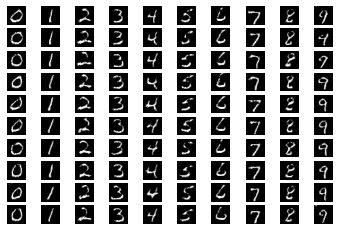

Epoch: 20 Loss D.: 0.4264296889305115, Loss G.: 2.145381212234497

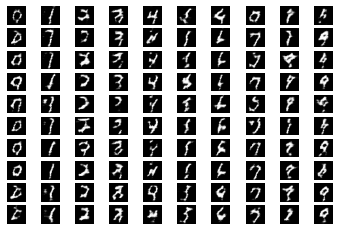

Epoch: 40 Loss D.: 0.4891084134578705, Loss G.: 1.7090198993682861

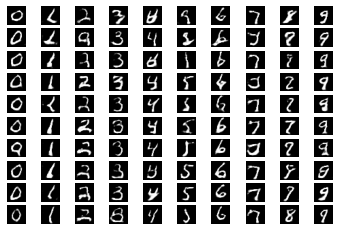

Epoch: 60 Loss D.: 0.44949787855148315, Loss G.: 1.4638139009475708

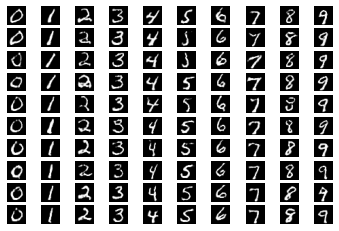

Epoch: 80 Loss D.: 0.8048756122589111, Loss G.: 0.8970762491226196

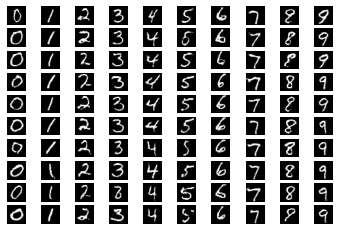

Epoch: 100 Loss D.: 0.5649224519729614, Loss G.: 1.2713171243667603

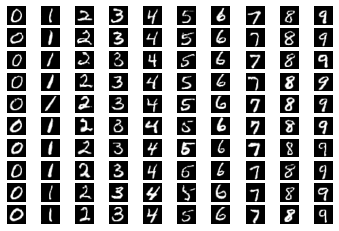

Epoch: 140 Loss D.: 0.5711784362792969, Loss G.: 0.914608359336853

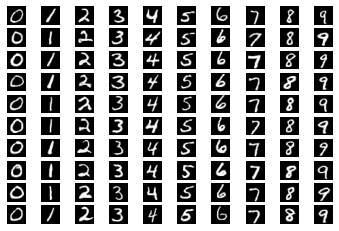

* Generator save

In [ ]:
##
torch.save(acgenerator, 'ACGANgenerator.pt')

In [ ]:
##!cp -r ./ACGANgenerator/ /gdrive/MyDrive/models/ACGANgenerator/

- model load

In [ ]:
generator = torch.load('ACGANgenerator.pt')

In [ ]:
r, c = 10, 10
fig = plt.figure(figsize=(7,7))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(c):
    noise_input = torch.randn((r, noise_dim))
    noise_label = np.eye(r, 10)[np.full(fill_value=i, shape=(r))]
    gen_imgs = acgenerator(torch.Tensor(noise_input).to(device), torch.Tensor(noise_label).to(device))###
    gen_imgs = 0.5 * gen_imgs + 0.5  # (0~1)<-(-1~1) scaling
    for j in range(r):
        ax = fig.add_subplot(r, c, j * r + i + 1)
        ax.imshow(gen_imgs.cpu().detach().numpy()[j,0,:,:], cmap=plt.cm.bone)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

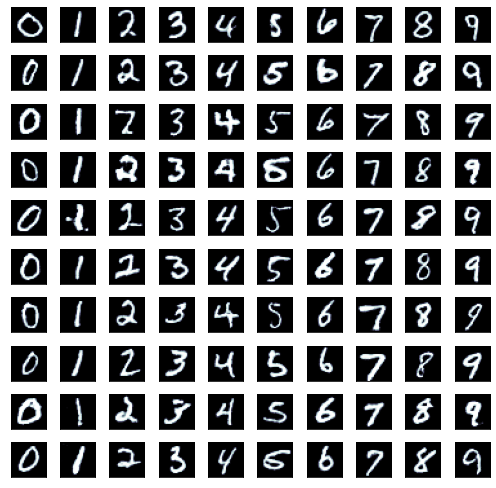

## infoGAN

### Dataset 준비

- model params

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 600
EPOCHS = 100
latent_code_dim=10  ## latent code
noise_dim = 90      ## z-vector
IN_PUT_DIM=latent_code_dim+noise_dim
num_examples_to_generate = 16
IMG_SHAPE=(1,28,28)

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST

class Normalize(object):
    def __call__(self, sample):
        sample = np.array(sample)
        image = (sample - 127.5) / 127.5
        return torch.FloatTensor(image).unsqueeze(dim=0)

class Onehot(object):
    def __call__(self, sample):
        sample = sample
        target = np.eye(10)[sample]
        return torch.FloatTensor(target)

# Normalize data to [-1 ~ 1]
mnist_transform = transforms.Compose([
    Normalize(), # noise add
])
target_transform = transforms.Compose([
    Onehot(), # noise add
])

# download path 정의
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True, target_transform=target_transform)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True, target_transform=target_transform)

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


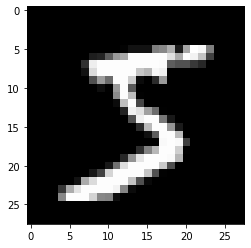

In [ ]:
plt.imshow(train_dataset[0][0][0, :, :], cmap='gray')
print(train_dataset[0][1])

In [ ]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, False)

### Model define

In [ ]:
# InfoGenerator model
class InfoGenerator(nn.Module):
    def __init__(self, input_dim):
        super(InfoGenerator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(input_dim, 256*7*7, bias=False),
            nn.Unflatten(1, (256, 7, 7)),   #(?,12544)
            nn.BatchNorm2d(256),            #(256,7,7)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 5, 1, padding=2, bias=False),
            nn.BatchNorm2d(128),            #(128,14,14)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2,
                               padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),             #(64,14,14)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 5, 2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh() )                     #(1,28,28)
    def forward(self, noise, label, code1, code2):
        noise = noise.to(device)
        label = label.to(device)
        code1 = code1.to(device)
        code2 = code2.to(device)
        inputs = torch.cat([noise, label, code1, code2], dim=1)
        out = self.generator(inputs)
        return out
info_generator = InfoGenerator(noise_dim+latent_code_dim+1+1)

summary(info_generator, input_size=[(BATCH_SIZE, noise_dim),
                                    (BATCH_SIZE, latent_code_dim),
                                    (BATCH_SIZE, 1), (BATCH_SIZE, 1)])

Layer (type:depth-idx)                   Output Shape              Param #
InfoGenerator                            [600, 1, 28, 28]          --
├─Sequential: 1-1                        [600, 1, 28, 28]          --
│    └─Linear: 2-1                       [600, 12544]              1,279,488
│    └─Unflatten: 2-2                    [600, 256, 7, 7]          --
│    └─BatchNorm2d: 2-3                  [600, 256, 7, 7]          512
│    └─LeakyReLU: 2-4                    [600, 256, 7, 7]          --
│    └─ConvTranspose2d: 2-5              [600, 128, 7, 7]          819,200
│    └─BatchNorm2d: 2-6                  [600, 128, 7, 7]          256
│    └─LeakyReLU: 2-7                    [600, 128, 7, 7]          --
│    └─ConvTranspose2d: 2-8              [600, 64, 14, 14]         204,800
│    └─BatchNorm2d: 2-9                  [600, 64, 14, 14]         128
│    └─LeakyReLU: 2-10                   [600, 64, 14, 14]         --
│    └─ConvTranspose2d: 2-11             [600, 1, 28, 28]        

In [ ]:
make_dot(info_generator(torch.zeros(BATCH_SIZE, noise_dim).to(device),
                        torch.zeros(BATCH_SIZE, latent_code_dim).to(device),
                        torch.zeros(BATCH_SIZE, 1).to(device),
                        torch.zeros(BATCH_SIZE, 1).to(device)),
         params=dict(info_generator.named_parameters())).render("info_generator", format="png")

In [ ]:
# InfoDiscriminator model
class InfoDiscriminator(nn.Module):
    def __init__(self, label_dim):
        super(InfoDiscriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, padding=2),  #(64,14,14)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, 2, padding=2),#(128,7,7)
            nn.LeakyReLU(),
            nn.Flatten() )
        self.discLinear = nn.Sequential(
            nn.Linear(128*7*7, 1),              #(?,1)
            )                #LS-GAN            #(real/fack)
#            nn.Sigmoid() )                      #(real/fack)
        self.firstLinear = nn.Linear(128*7*7, 128)
        self.acLinear = nn.Linear(128, label_dim)#(labels)
        self.code1Linear = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid() )                      #(code1)
        self.code2Linear = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid() )                      #(code2)
    def forward(self, x):
        out = self.discriminator(x)
        disc_out = self.discLinear(out)         #(real/fack)
        out2 = self.firstLinear(out)            #(?,128)
        label_out = self.acLinear(out2)         #(labels)
        code1 = self.code1Linear(out2)          #(code1)
        code2 = self.code2Linear(out2)          #(code2)
        return disc_out, label_out, code1, code2

info_discriminator = InfoDiscriminator(latent_code_dim).to(device)
summary(info_discriminator, input_size=[(BATCH_SIZE, 1, 28, 28)])

Layer (type:depth-idx)                   Output Shape              Param #
InfoDiscriminator                        [600, 1]                  --
├─Sequential: 1-1                        [600, 6272]               --
│    └─Conv2d: 2-1                       [600, 64, 14, 14]         1,664
│    └─LeakyReLU: 2-2                    [600, 64, 14, 14]         --
│    └─Conv2d: 2-3                       [600, 128, 7, 7]          204,928
│    └─LeakyReLU: 2-4                    [600, 128, 7, 7]          --
│    └─Flatten: 2-5                      [600, 6272]               --
├─Sequential: 1-2                        [600, 1]                  --
│    └─Linear: 2-6                       [600, 1]                  6,273
├─Linear: 1-3                            [600, 128]                802,944
├─Linear: 1-4                            [600, 10]                 1,290
├─Sequential: 1-5                        [600, 1]                  --
│    └─Linear: 2-7                       [600, 1]                 

### Model 생성 및 학습조건 설정

In [ ]:
### mutual information 계산
# noise z와 code c를 가지고 생성한 이미지 x
# 이미지 x로 부터 구한 코드 c'
# c분포와 c'분포의 cross entropy 계산
# mi_loss = - c * log(Q(c|x))
def mi_loss(q_of_c_given_x, c):
    r = -torch.mean(torch.sum(
          c * torch.log( q_of_c_given_x + 1e-7), dim=1 ))
    return r

In [ ]:
lr = 2e-4
decay = 6e-8
#bce_loss = nn.MSELoss() #LS-GAN
bce_loss = nn.BCELoss()
cce_loss = nn.CrossEntropyLoss()
mi_loss = mi_loss
info_generator = info_generator.to(device)
info_discriminator = info_discriminator.to(device)
optimizer_generator = torch.optim.RMSprop(info_generator.parameters(), lr=lr*0.5,weight_decay=decay*0.5)
optimizer_discriminator = torch.optim.RMSprop(info_discriminator.parameters(), lr=lr,weight_decay=decay)

In [ ]:
def generate_and_save_images(model, epoch):
    r, c = 10, 10
    fig, axs = plt.subplots(r, c)
    for i in range(c):
        noise_input = torch.Tensor(np.random.uniform(-1.0,1.0,size=[r, noise_dim])).to(device)
        noise_label = torch.Tensor(np.eye(r, 10)[np.full(fill_value=i, shape=(r))]).to(device)
        code_std = 2
        a = torch.linspace(-code_std, code_std, 10).view(-1, 1).to(device)
        noise_code1 = torch.ones((10, 1)).to(device) * a
        a = torch.linspace(-code_std, code_std, 10).view(-1, 1).to(device)
        noise_code2 = torch.ones((10, 1)).to(device) * a

        gen_imgs = model(noise_input, noise_label, noise_code1, noise_code2)###
        gen_imgs = 0.5 * gen_imgs + 0.5  # (0~1)<-(-1~1) scaling
        for j in range(r):
            axs[j,i].imshow(gen_imgs.cpu().detach().numpy()[j,0,:,:], cmap='gray')
            axs[j,i].axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training

CPU times: user 34min 21s, sys: 2min 13s, total: 36min 35s   
Wall time: 48min 34s

In [ ]:
%%time
EPOCHS = 100
for epoch in range(EPOCHS):
    for real_imgs, real_labels in train_dataloader:
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        yb_real = torch.Tensor(BATCH_SIZE,1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(BATCH_SIZE,1).fill_(0.0).to(device) # fake_label
        real_code1= torch.Tensor(np.random.normal(scale=0.5,size=[BATCH_SIZE, 1])).to(device)
        real_code2= torch.Tensor(np.random.normal(scale=0.5,size=[BATCH_SIZE, 1])).to(device)
        # Generate fake image, label, codes
        noise = torch.Tensor(np.random.uniform(-1.0,1.0,size=[BATCH_SIZE, noise_dim])).to(device)
        fakelabel = np.random.randint(0, 10, BATCH_SIZE)
        fakelabel = torch.Tensor(np.eye(BATCH_SIZE, 10)[fakelabel]).to(device)
        fake_code1= torch.Tensor(np.random.normal(scale=0.5,size=[BATCH_SIZE, 1])).to(device)
        fake_code2= torch.Tensor(np.random.normal(scale=0.5,size=[BATCH_SIZE, 1])).to(device)
        fake_img = info_generator(noise, fakelabel, fake_code1, fake_code2)
        # Discriminator training
        info_discriminator.zero_grad()
        dis_out, label_out, code1_out, code2_out = info_discriminator(real_imgs)
        loss_real_ce = bce_loss(dis_out, yb_real) + cce_loss(label_out, real_labels)
        loss_real_mi = (mi_loss(code1_out, real_code1)+ mi_loss(code2_out, real_code2))/2
        loss_real = loss_real_ce + loss_real_mi
        dis_out, label_out, code1_out, code2_out = info_discriminator(fake_img.detach())
        loss_fake_ce = bce_loss(dis_out, yb_fake) + cce_loss(label_out, fakelabel)
        loss_fake_mi = (mi_loss(code1_out, fake_code1)+ mi_loss(code2_out, fake_code2))/2
        loss_fake = loss_fake_ce + loss_fake_mi
        loss_dis = (loss_real + loss_fake)/2
        loss_dis.backward()
        optimizer_discriminator.step()

        # Generator training
        info_generator.zero_grad()
        # Generate fake image, label, codes
        noise = torch.Tensor(np.random.uniform(-1.0,1.0,size=[BATCH_SIZE, noise_dim])).to(device)
        fakelabel = np.random.randint(0, 10, BATCH_SIZE)
        fakelabel = torch.Tensor(np.eye(BATCH_SIZE, 10)[fakelabel]).to(device)
        fake_code1= torch.Tensor(np.random.normal(scale=0.5,size=[BATCH_SIZE, 1])).to(device)
        fake_code2= torch.Tensor(np.random.normal(scale=0.5,size=[BATCH_SIZE, 1])).to(device)
        fake_img = info_generator(noise, fakelabel, fake_code1, fake_code2)
        dis_out, label_out, code1_out, code2_out = info_discriminator(fake_img)
        loss_gen_ce = bce_loss(dis_out, yb_real) + cce_loss(label_out, fakelabel)
        loss_gen_mi = (mi_loss(code1_out, fake_code1)+ mi_loss(code2_out, fake_code2))/2
        loss_gen = loss_gen_ce + loss_gen_mi
        loss_gen.backward()
        optimizer_generator.step()

    if epoch % 10 ==0:
        print(f"Epoch: {epoch} Loss D:{loss_dis}, Loss G:{loss_gen}")
        generate_and_save_images(info_generator, epoch)
    else :
        print(f"Epoch: {epoch} Loss D:{loss_dis}, Loss G:{loss_gen}")


RuntimeError: ignored

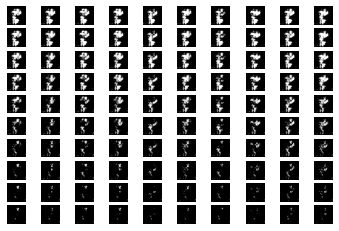

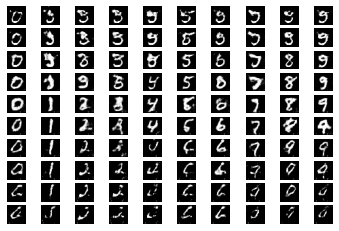

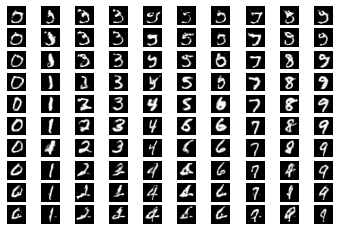

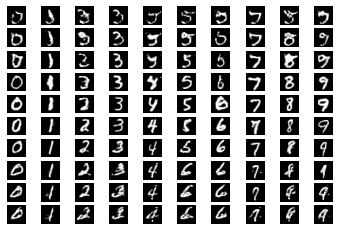

Epoch: 99 Loss D:-1.4085789918899536, Loss G:-2.5970637798309326  
CPU times: user 15min 13s, sys: 4.9 s, total: 15min 18s  
Wall time: 15min 15s

In [ ]:
torch.save(info_generator, 'infoGANgenerator.pt')

In [ ]:
#!cp -r ./infoGANgenerator/ /gdrive/MyDrive/models/infoGANgenerator/

- Model load

In [ ]:
info_generator = torch.load('infoGANgenerator.pt')

### latent code1,2 특징 확인

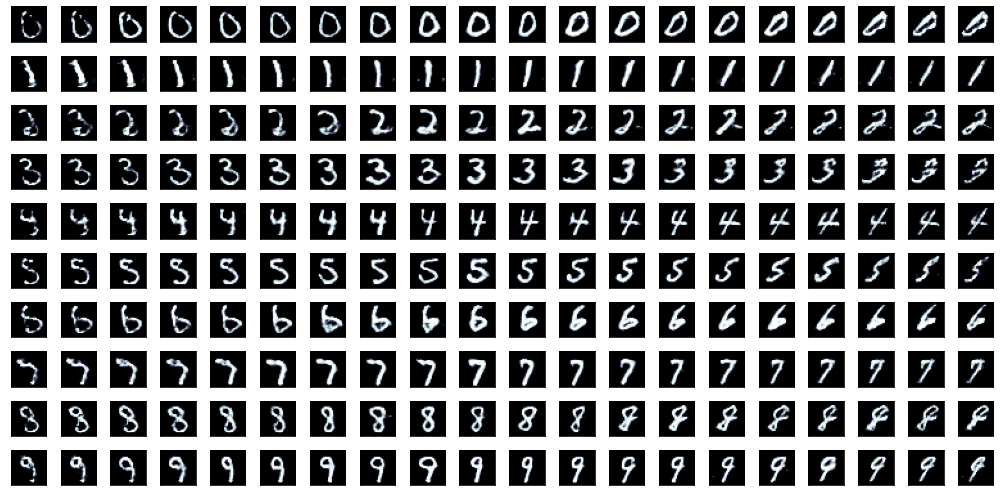

In [ ]:
r, c = 10, 20
code1_l = -2   #code1_min
code1_h = 2    #code1_max
code2_l = -0   #code2_min
code2_h = 0    #code2_max

fig = plt.figure(figsize=(14,7))
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.01,right=0.99)
for i in range(r):
    noise_input = torch.rand([c, noise_dim]).to(device) # (20,90)
    # class label (20,10)
    noise_label = torch.FloatTensor(np.eye(10)[np.full(fill_value=i, shape=(c,))]).to(device)
    noise_code1 = torch.linspace(code1_l, code1_h, c).view(c, 1).to(device)# code1 (20, 1)
    noise_code2 = torch.linspace(code2_l, code2_h, c).view(c, 1).to(device)# code2 (20, 1)
    # 20개 이미지 추론           ([(20,90),(20,10),(20,1),(20,1)])
    gen_imgs = info_generator(noise_input, noise_label, noise_code1, noise_code2)
    gen_imgs = 0.5 * gen_imgs + 0.5  # (0~1)<-(-1~1) scaling
    for j in range(c): # 20개 이미지 출력
        ax = fig.add_subplot(r, c, i * c + j + 1)
        ax.imshow(gen_imgs.cpu().detach().numpy()[j,0,:,:], cmap=plt.cm.bone)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

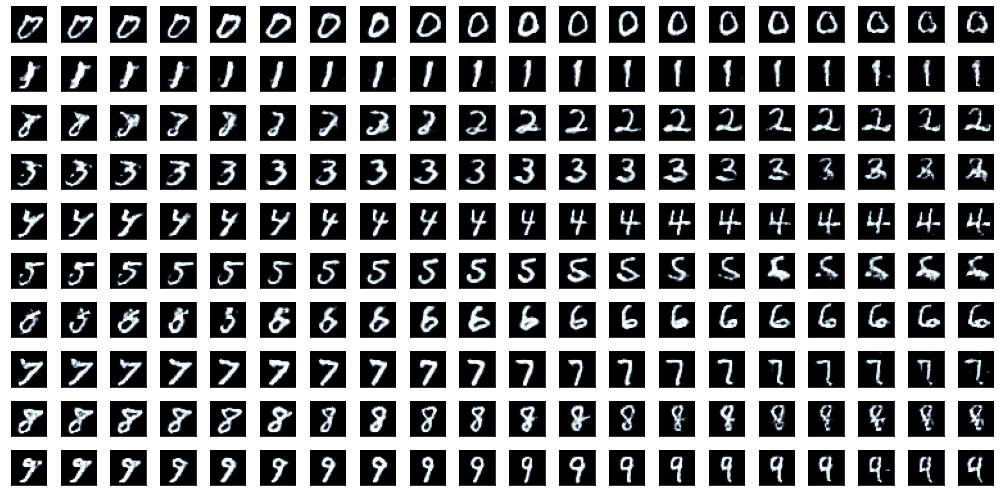

In [ ]:
r, c = 10, 20
code1_l = -0    #code1_min
code1_h = 0     #code1_max
code2_l = -2    #code2_min
code2_h = 2     #code2_max

fig = plt.figure(figsize=(14,7))
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.01,right=0.99)
for i in range(r):
    noise_input = torch.rand([c, noise_dim]).to(device) # (20,90)
    # class label (20,10)
    noise_label = torch.FloatTensor(np.eye(10)[np.full(fill_value=i, shape=(c,))]).to(device)
    noise_code1 = torch.linspace(code1_l, code1_h, c).view(c, 1).to(device)# code1 (20, 1)
    noise_code2 = torch.linspace(code2_l, code2_h, c).view(c, 1).to(device)# code2 (20, 1)
    # 20개 이미지 추론           ([(20,90),(20,10),(20,1),(20,1)])
    gen_imgs = info_generator(noise_input, noise_label, noise_code1, noise_code2)
    gen_imgs = 0.5 * gen_imgs + 0.5  # (0~1)<-(-1~1) scaling
    for j in range(c): # 20개 이미지 출력
        ax = fig.add_subplot(r, c, i * c + j + 1)
        ax.imshow(gen_imgs.cpu().detach().numpy()[j,0,:,:], cmap=plt.cm.bone)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()